# import modules

In [1]:
# importing modules

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
import sys
import pickle
import joblib as jl
import os
import gc
import seaborn as sb

from itertools import product

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization

from tensorflow.keras.regularizers import l1, l2

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

from tensorflow.math import confusion_matrix

tf.test.gpu_device_name()
tf.device('/GPU:0')

import optuna
from optuna.samplers import TPESampler

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import multiprocessing
cores=multiprocessing.cpu_count()-5

2024-12-18 08:37:56.178839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-18 08:37:59.886941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 08:37:59.896630: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-18 08:38:00.603805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 08:38:00.603864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name:

In [2]:

# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")
from tensorflow.python.platform import build_info

print("CUDA version:", build_info.build_info['cuda_version'])
print("cuDNN version:", build_info.build_info['cudnn_version'])


TensorFlow Version: 2.5.0
CUDA version: 11.2
cuDNN version: 8


In [3]:
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
num_classes = 19 #0 - 18
np.random.seed(441) #setting seed
img_rows, img_cols = 28, 56 #image dimensions

#.keras and .pkl names
num = "999"
s_name = f"study{num}"
m_name = f"model{num}"
smp_name = f"sampler{num}"
h_name = f"history{num}"

# the data, split between train and test sets
(x_train_in, y_train_in), (x_test_in, y_test_in) = mnist.load_data()

x_train_in = x_train_in.astype('float32')
x_train_in /= 255.0

x_test_in = x_test_in.astype('float32')
x_test_in /= 255.0


In [5]:
def jl_pairs(i, j, pairs_per_combination, X, Y):
    idxl1 = np.where(Y == i)[0]
    idxl2 = np.where(Y == j)[0]

    imgs = []
    labels = []

    for k in range(pairs_per_combination):
        idx1 = np.random.choice(idxl1)
        idx2 = np.random.choice(idxl2)
        combined_img = np.hstack((X[idx1], X[idx2]))
        combined_label = i+j
        imgs.append(combined_img)
        labels.append(combined_label)

    return imgs, labels

def jl_dataset(X, Y, output=100000, n_jobs=cores):

    pairs_per_combination = int(output)//100
    results = jl.Parallel(n_jobs=n_jobs)(jl.delayed(jl_pairs)(i, j, pairs_per_combination, X, Y) for i in range(10) for j in range(10))
    
    imgs = []
    labels = []

    for ri, rl in results:
        imgs.extend(ri)
        labels.extend(rl)

    shuffle_idx = np.random.permutation((len(imgs)))
    imgs = np.array(imgs)[shuffle_idx]
    labels = np.array(labels)[shuffle_idx]
    
    return imgs, labels

In [6]:
def get_data(output=100000, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):

    np.random.seed(442)
    train_shuffle_idx = np.random.permutation(len(x_train_in))
    x_train = x_train_in[train_shuffle_idx]
    y_train = y_train_in[train_shuffle_idx]

    test_shuffle_idx = np.random.permutation(len(x_test_in))
    x_test = x_test_in[test_shuffle_idx]
    y_test = y_test_in[test_shuffle_idx]
    
    tv_ratio = round(val_ratio/(1-train_ratio), 2)

    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=tv_ratio, random_state=441)

    x_train, y_train = jl_dataset(x_train, y_train, output=int(output*train_ratio))
    
    x_test, y_test = jl_dataset(x_test, y_test, output=int(output*test_ratio))

    x_val, y_val= jl_dataset(x_val, y_val, output=int(output*val_ratio))

    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    return x_train, y_train, x_test, y_test, x_val, y_val

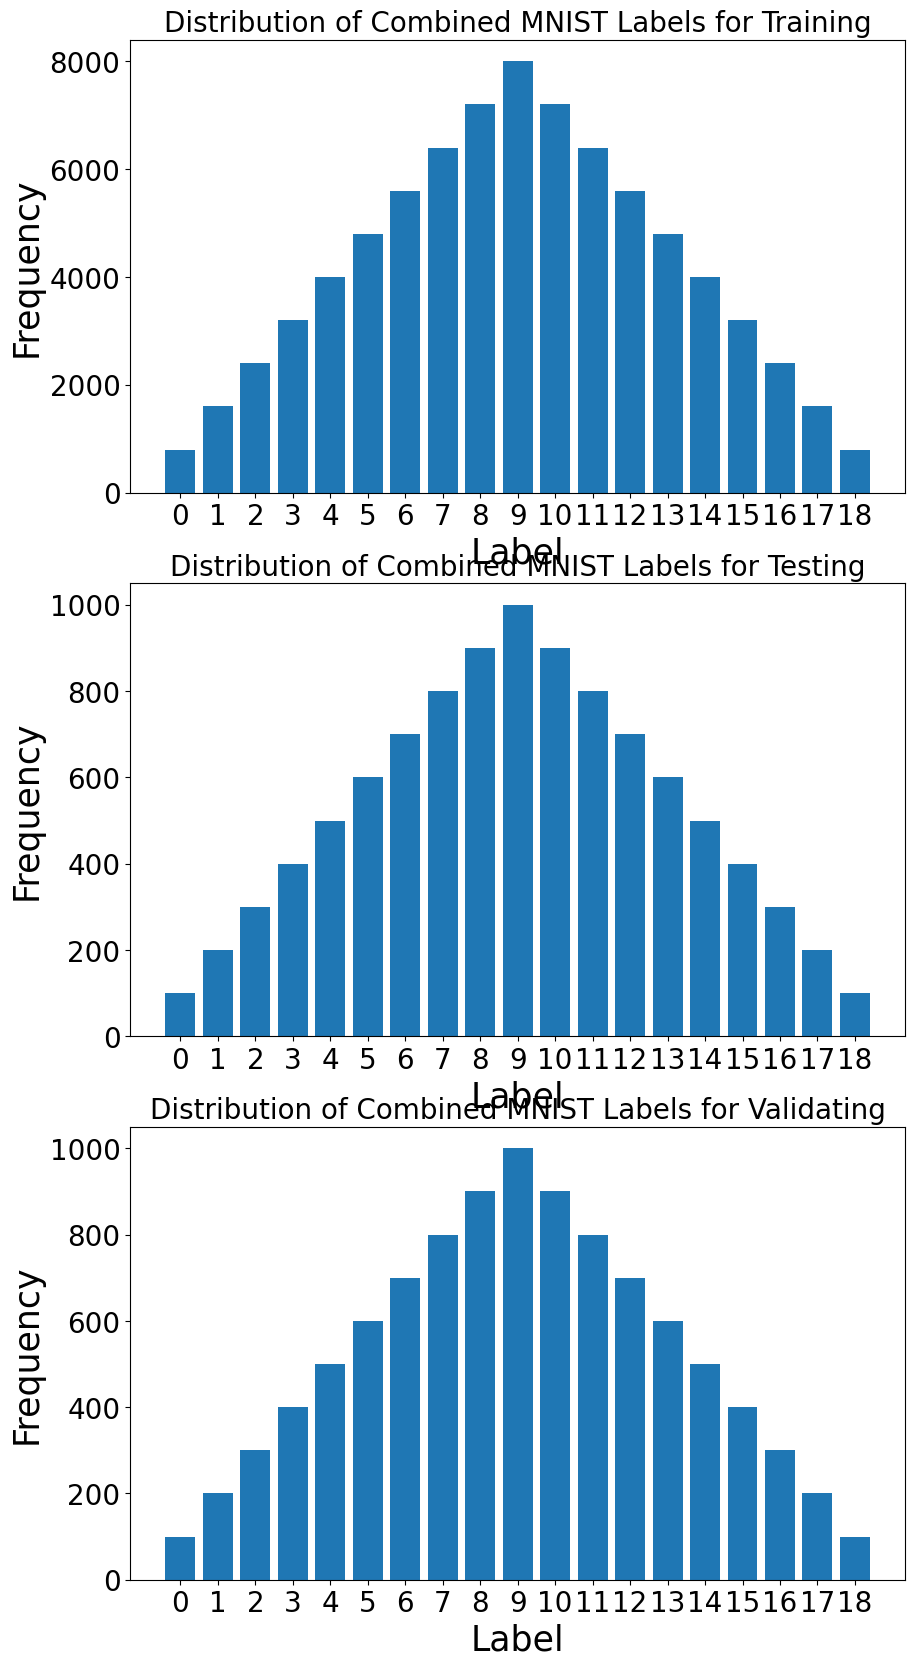

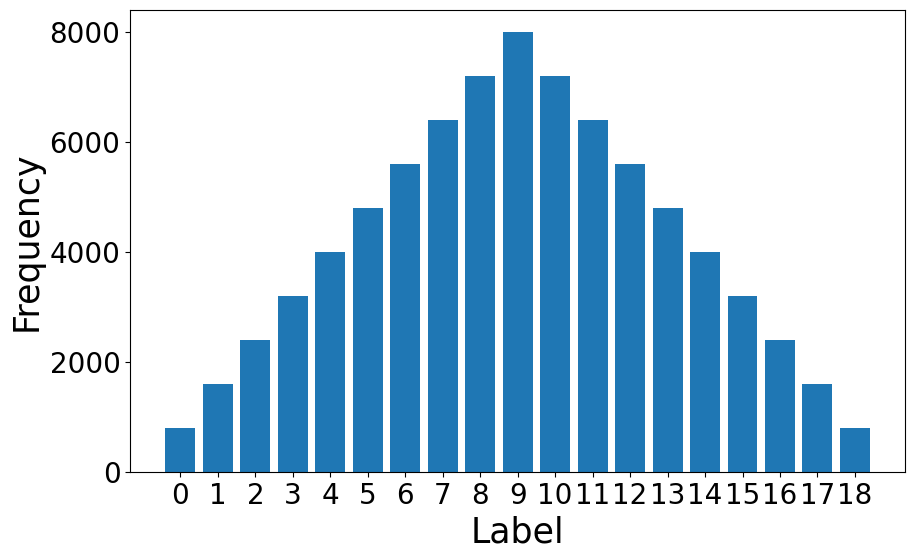

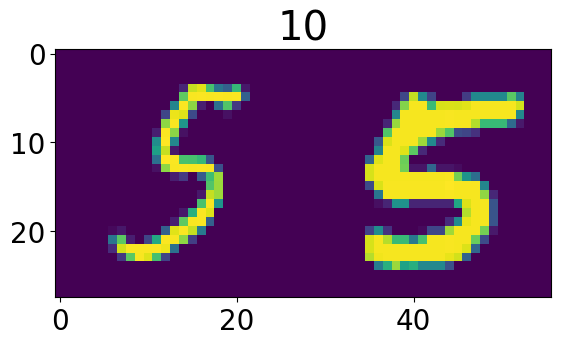

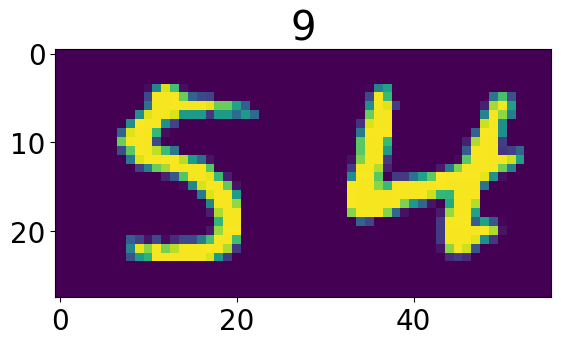

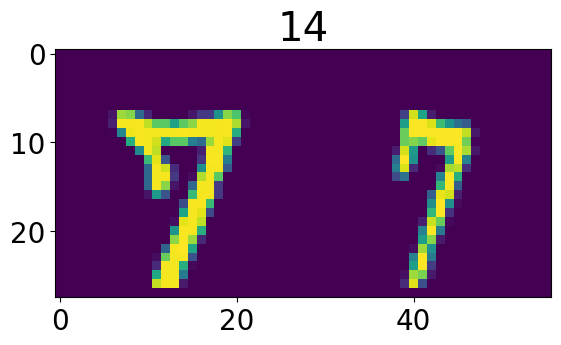

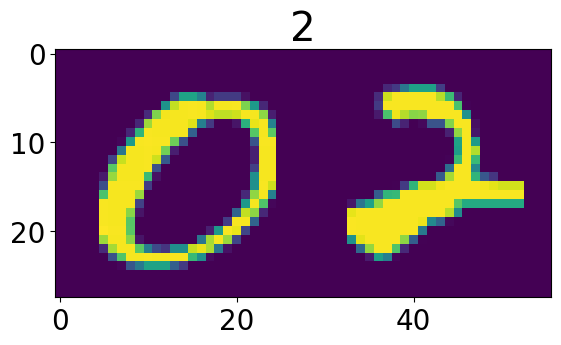

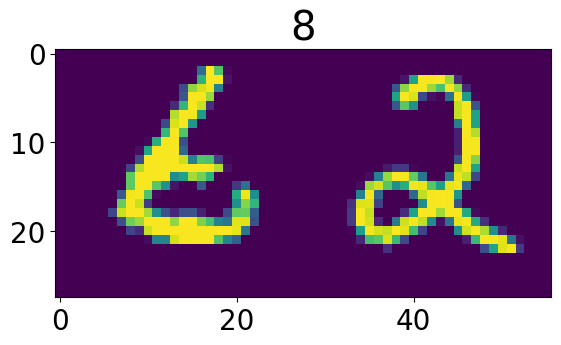

In [7]:
def plot_dists():
    x_train, y_train, x_test, y_test, x_val, y_val = get_data()
    label = [y_train, y_test, y_val]
    labels = [np.argmax(y, axis=1) for y in label]
    labels_title = ["training", "testing", "validating"]

    fig, axs = plt.subplots(3, figsize=(10, 20))
    for i in range(len(labels)):
        axs[i].hist(labels[i], bins=np.arange(20) - 0.5, rwidth=0.8)
        axs[i].set_title(f'Distribution of Combined MNIST Labels for {labels_title[i].capitalize()}', fontsize=20)
        axs[i].set_xlabel('Label')
        axs[i].set_ylabel('Frequency')
        axs[i].set_xticks(range(19))

    fig.savefig('Y_split_dist.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(labels[0], bins=np.arange(20)-0.5, rwidth=0.8)
    ax.set_xlabel('Label')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(19))
    fig.savefig("Y_dist_many.png")
    plt.show()

    for i in range(5):
        plt.imshow(x_train[i])
        plt.title(np.where(y_train[i]==1)[0][0], fontsize=29)
        plt.show()

plot_dists()

# neural network


In [8]:
x_train, y_train, x_test, y_test, x_val, y_val = get_data()

In [8]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True) #3
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.5)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-5, 1e-3)
    n_layers = trial.suggest_int('n_layers', 4, 6)
    batch_size = trial.suggest_int('batch_size', 16, 256)
    
    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols)))

    neurons = [2**n * 64 for n in range(n_layers)][::-1]

    for i in range(n_layers):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(l2_regularization)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
    model_checkpoint = ModelCheckpoint(f"nn_best_{m_name}.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=0)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=batch_size, verbose=0, callbacks=[model_checkpoint, early_stopping, reduce_lr])
    
    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]

    backend.clear_session()
    del model
    gc.collect()

    return accuracy

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=441))

study.optimize(objective, n_trials=50, show_progress_bar=True)

print('Best trial:')
print(f' Value: {study.best_trial.value}')
print(' Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

with open(f"nn_{s_name}.pkl", "wb") as f:
    pickle.dump(study, f)

with open(f'nn_best_{s_name}_params.pkl', 'wb') as f:
    pickle.dump(study.best_trial.params, f)

with open(f"nn_{smp_name}.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

[I 2024-12-11 08:38:18,288] A new study created in memory with name: no-name-65ec77d6-2eff-4a9f-91fa-f46b0c3c170e


  0%|          | 0/50 [00:00<?, ?it/s]

2024-12-11 08:38:18.751740: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.
2024-12-11 08:38:18.843672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-12-11 08:38:18.845098: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2918395000 Hz
2024-12-11 08:38:19.668758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-12-11 08:38:20.857408: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-12-11 08:38:20.857479: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[I 2024-12-11 08:39:10,402] Trial 0 finished with value: 0.9269999861717224 and parameters: {'learning_rate': 0.0008755439843430998, 'dropout_rate': 0.20418470466361796, 'l2_regularization': 2.6323105487332633e-05, 'n_layers': 6, 'batch_size': 211}. Best is trial 0 with value: 0.9269999861717224.


2024-12-11 08:39:10.461625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.


[I 2024-12-11 08:41:15,486] Trial 1 finished with value: 0.939300000667572 and parameters: {'learning_rate': 0.00048215780346319185, 'dropout_rate': 0.16662979401340552, 'l2_regularization': 0.00023459489516765956, 'n_layers': 4, 'batch_size': 113}. Best is trial 1 with value: 0.939300000667572.


2024-12-11 08:41:15.560161: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.


[I 2024-12-11 08:42:48,710] Trial 2 finished with value: 0.9395999908447266 and parameters: {'learning_rate': 0.0003161752390068829, 'dropout_rate': 0.2249190259621615, 'l2_regularization': 0.0005027765651364822, 'n_layers': 6, 'batch_size': 190}. Best is trial 2 with value: 0.9395999908447266.


2024-12-11 08:42:48.772501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.


[I 2024-12-11 08:49:26,617] Trial 3 finished with value: 0.9380999803543091 and parameters: {'learning_rate': 0.00038393318792467293, 'dropout_rate': 0.061071083562554564, 'l2_regularization': 0.000586111687255104, 'n_layers': 5, 'batch_size': 37}. Best is trial 2 with value: 0.9395999908447266.


2024-12-11 08:49:26.685435: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.


[I 2024-12-11 08:50:48,315] Trial 4 finished with value: 0.9301999807357788 and parameters: {'learning_rate': 0.0004306593639460271, 'dropout_rate': 0.038512486414655246, 'l2_regularization': 0.0004244719239179592, 'n_layers': 5, 'batch_size': 195}. Best is trial 2 with value: 0.9395999908447266.
[I 2024-12-11 08:51:57,699] Trial 5 finished with value: 0.9386000037193298 and parameters: {'learning_rate': 0.0002677667034338071, 'dropout_rate': 0.1354706676856213, 'l2_regularization': 0.0005939480625348585, 'n_layers': 5, 'batch_size': 234}. Best is trial 2 with value: 0.9395999908447266.
[I 2024-12-11 08:53:12,742] Trial 6 finished with value: 0.8235999941825867 and parameters: {'learning_rate': 3.296849432827099e-05, 'dropout_rate': 0.20918949293674183, 'l2_regularization': 0.0008876195336839763, 'n_layers': 5, 'batch_size': 209}. Best is trial 2 with value: 0.9395999908447266.
[I 2024-12-11 08:55:05,378] Trial 7 finished with value: 0.257099986076355 and parameters: {'learning_rate': 

In [9]:
def create_and_save_model():
    with open(f'nn_best_{s_name}_params.pkl', 'rb') as f:
        params = pickle.load(f)

    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols)))

    neurons = [2**n * 64 for n in range(params.get('n_layers'))][::-1]

    for i in range(params.get('n_layers')):
        model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(params.get('l2_regularization'))))
        model.add(Dropout(params.get('dropout_rate')))
        model.add(BatchNormalization())

    model.add(Dense(num_classes,activation='softmax'))

    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50,
                        batch_size=params.get('batch_size'), verbose=1)

    score = model.evaluate(x_test, y_test, verbose=0)
    accuracy = score[1]
    print(accuracy)
    model.save(f'nn_fitted_{m_name}.keras')
    with open(f'nn_fitted_{h_name}.pkl', "wb") as file:
        pickle.dump(history.history, file)

create_and_save_model()

Epoch 1/50
1160/1160 [==============================] - 17s 14ms/step - loss: 2.6640 - accuracy: 0.4164 - val_loss: 1.4888 - val_accuracy: 0.7829
Epoch 2/50
1160/1160 [==============================] - 15s 13ms/step - loss: 1.5494 - accuracy: 0.7516 - val_loss: 1.1557 - val_accuracy: 0.8619
Epoch 3/50
1160/1160 [==============================] - 15s 13ms/step - loss: 1.2157 - accuracy: 0.8427 - val_loss: 1.0163 - val_accuracy: 0.8914
Epoch 4/50
1160/1160 [==============================] - 14s 12ms/step - loss: 1.0358 - accuracy: 0.8815 - val_loss: 0.9395 - val_accuracy: 0.9040
Epoch 5/50
1160/1160 [==============================] - 14s 12ms/step - loss: 0.9146 - accuracy: 0.9051 - val_loss: 0.8652 - val_accuracy: 0.9151
Epoch 6/50
1160/1160 [==============================] - 14s 12ms/step - loss: 0.8199 - accuracy: 0.9204 - val_loss: 0.8121 - val_accuracy: 0.9214
Epoch 7/50
1160/1160 [==============================] - 14s 12ms/step - loss: 0.7476 - accuracy: 0.9304 - val_loss: 0.7706 -

In [9]:
model = load_model(f'nn_fitted_{m_name}.keras')
sampler = pickle.load(open(f"nn_{smp_name}.pkl", "rb"))
history = pickle.load(open(f"nn_fitted_{h_name}.pkl", "rb"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3213312   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [10]:
model.evaluate(x_test, y_test)

2024-12-17 22:19:44.557333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 62720000 exceeds 10% of free system memory.
2024-12-17 22:19:44.666240: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-12-17 22:19:44.674170: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2918400000 Hz
2024-12-17 22:19:45.067623: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  2/313 [..............................] - ETA: 17s - loss: 0.4397 - accuracy: 0.9062  

2024-12-17 22:19:48.682786: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-12-17 22:19:48.685018: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 8s 12ms/step - loss: 0.3832 - accuracy: 0.9549


[0.38323915004730225, 0.9549000263214111]

# predictions

2024-12-18 02:26:19.844509: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-12-18 02:26:19.848579: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2918400000 Hz
2024-12-18 02:26:20.008734: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-12-18 02:26:21.535837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-12-18 02:26:21.536046: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


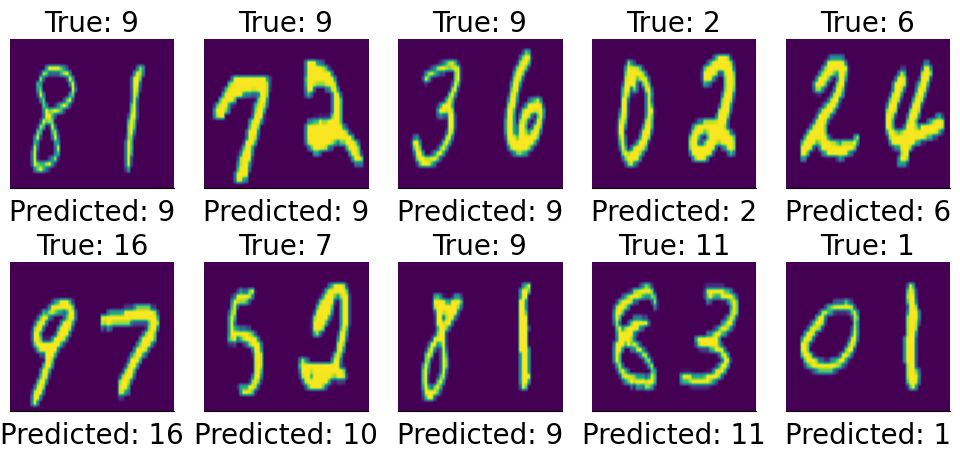

: 

In [10]:
def nn_predict():
    np.random.seed(221)
    model = load_model(f'nn_fitted_{m_name}.keras')
    predictions = model.predict(x_test)
    size=10
    cols=int(10/2)
    idxs = np.random.choice(len(x_test), size=size, replace=False)

    fig, axs = plt.subplots(2, cols, figsize=(10, 5))

    for i in range(cols):
        for j in range(2):
            idx = idxs[i + j*5]
            secax = axs[j, i].secondary_xaxis('bottom')
            secax.set_xlabel(f"Predicted: {np.argmax(predictions, axis=1)[idx]}", fontsize=20)
            axs[j, i].imshow(x_test[idx], aspect='auto')
            axs[j, i].set_title(f"True: {np.argmax(y_test, axis=1)[idx]}", fontsize=20)
            axs[j, i].axis('off')
            secax.set_xticks([])
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.savefig("nn_predictions.png")
    plt.show()

nn_predict()

# confusion matrix

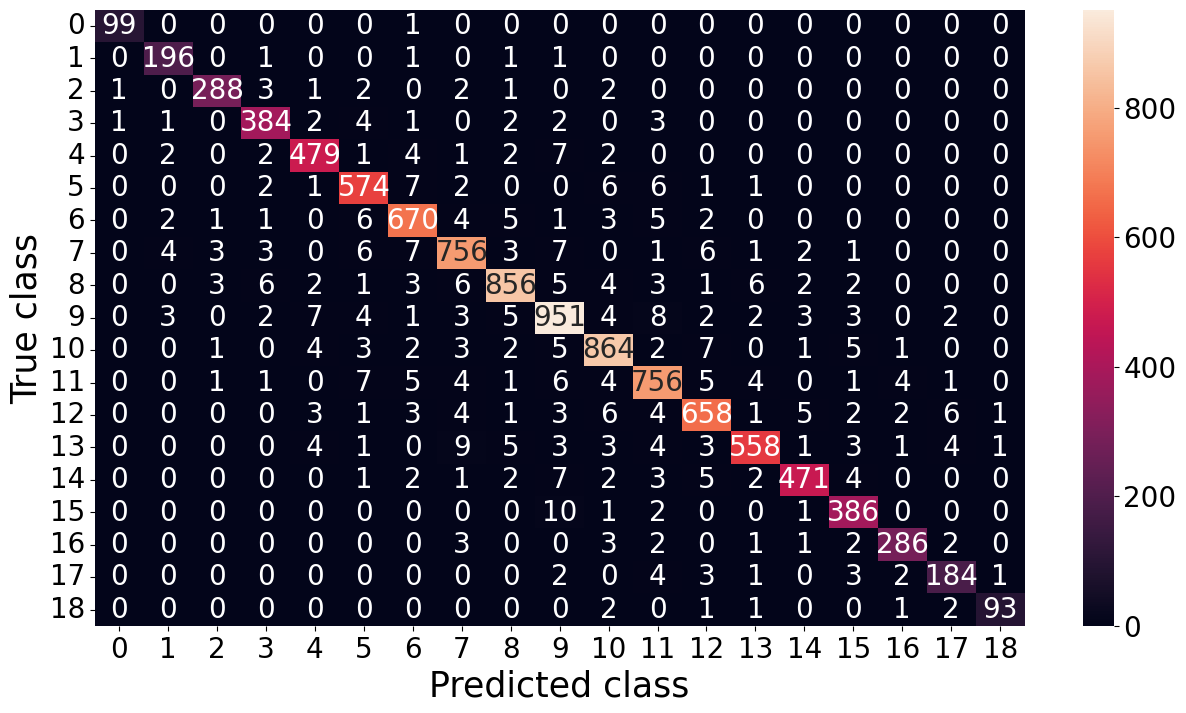

In [12]:
def confusion_matrix_plot():
    """
    Plots confusion matrix of neural network.
    """
    np.random.seed(221)
    model = load_model(f'nn_fitted_{m_name}.keras')
    predictions = model.predict(x_test)
    confusion = confusion_matrix(labels=np.argmax(y_test, axis=1), predictions=np.argmax(predictions, axis=1), num_classes=num_classes)
    fig, ax = plt.subplots(figsize=(15, 8))
    ax = sb.heatmap(confusion, annot=True, fmt='g')
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    # ax.set_title(f"Confusion Matrix for best-performing neural network", fontsize=20)
    plt.savefig(f"confusion_nn.png")

confusion_matrix_plot()

# tsne

In [9]:
def get_embeddings(x_train, save=True):
    model = load_model(f'nn_fitted_{m_name}.keras')

    with open(f'nn_best_{s_name}_params.pkl', 'rb') as f:
        params = pickle.load(f)
        
    model.compile(optimizer=Adam(params.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy'])
    
    embedding_layer = model.get_layer('dense_5')
    embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
    embeddings = embedding_model.predict(x_train)
    
    if save:
        embedding_model.save(f'nn_embedded_{m_name}.keras')
        with open(f'nn_embeddings{num}.pkl', "wb") as file:
            pickle.dump(embeddings, file)
    else:
        return embeddings, embedding_model

In [28]:
def get_TSNE():

    x_train_flat = x_train.reshape(-1, 1568)
    y_train_flat = y_train.astype(int)

    get_embeddings(x_train)

    with open(f'nn_embeddings{num}.pkl', "rb") as file:
        embeddings = pickle.load(file)

    perplexities = [5, 30, 50, 100]#, 200]

    fig, axs = plt.subplots(nrows=len(perplexities), ncols=2, figsize=(12, 20))
    secax = axs[0, 0].secondary_xaxis('top')
    secax2 = axs[0, 1].secondary_xaxis('top')
    
    secax.set_xlabel(f"Perplexity: {perplexities[0]}", fontsize=20)
    secax.set_xticks([])
    secax2.set_xlabel(f"Perplexity: {perplexities[0]}", fontsize=20)
    secax2.set_xticks([])

    for i in range(len(perplexities)):
        tsne = TSNE(n_components=2, perplexity=perplexities[i], random_state=441, max_iter=2000, n_iter_without_progress=400)
        model_embedded = tsne.fit_transform(embeddings[:5000])

        if i==0:
            axs[i, 0].set_title(f"Input dataset", fontsize=20)
            axs[i, 1].set_title(f"Embedding layer", fontsize=20)
        else:
            axs[i, 0].set_title(f"Perplexity: {perplexities[i]}", fontsize=20)
            axs[i, 1].set_title(f"Perplexity: {perplexities[i]}", fontsize=20)


        x_embedded = tsne.fit_transform(x_train_flat[:5000])
        # print(x_embedded.shape, y_train_flat[:5000].shape, print(y_train_flat[:10]))
        x_scatter = axs[i, 0].scatter(x_embedded[:, 0], x_embedded[:, 1], c=np.argmax(y_train_flat[:5000], axis=1), cmap='tab20', s=1)
        axs[i, 0].set_xlabel("t-SNE Dim 1",fontsize=20)
        axs[i, 0].set_ylabel("t-SNE Dim 2",fontsize=20)

        model_scatter = axs[i, 1].scatter(model_embedded[:, 0], model_embedded[:, 1], c=np.argmax(y_train_flat[:5000], axis=1), cmap='tab20', s=1)
        axs[i, 1].set_xlabel("t-SNE Dim 1",fontsize=20)
        axs[i, 1].set_ylabel("t-SNE Dim 2",fontsize=20)

        

        del model_embedded

    fig.subplots_adjust(hspace=0.3, wspace=0.5,right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(model_scatter, cax=cbar_ax, orientation='vertical', label='Classes')

    # fig.tight_layout()
    fig.savefig("tsne.png")
    plt.show()

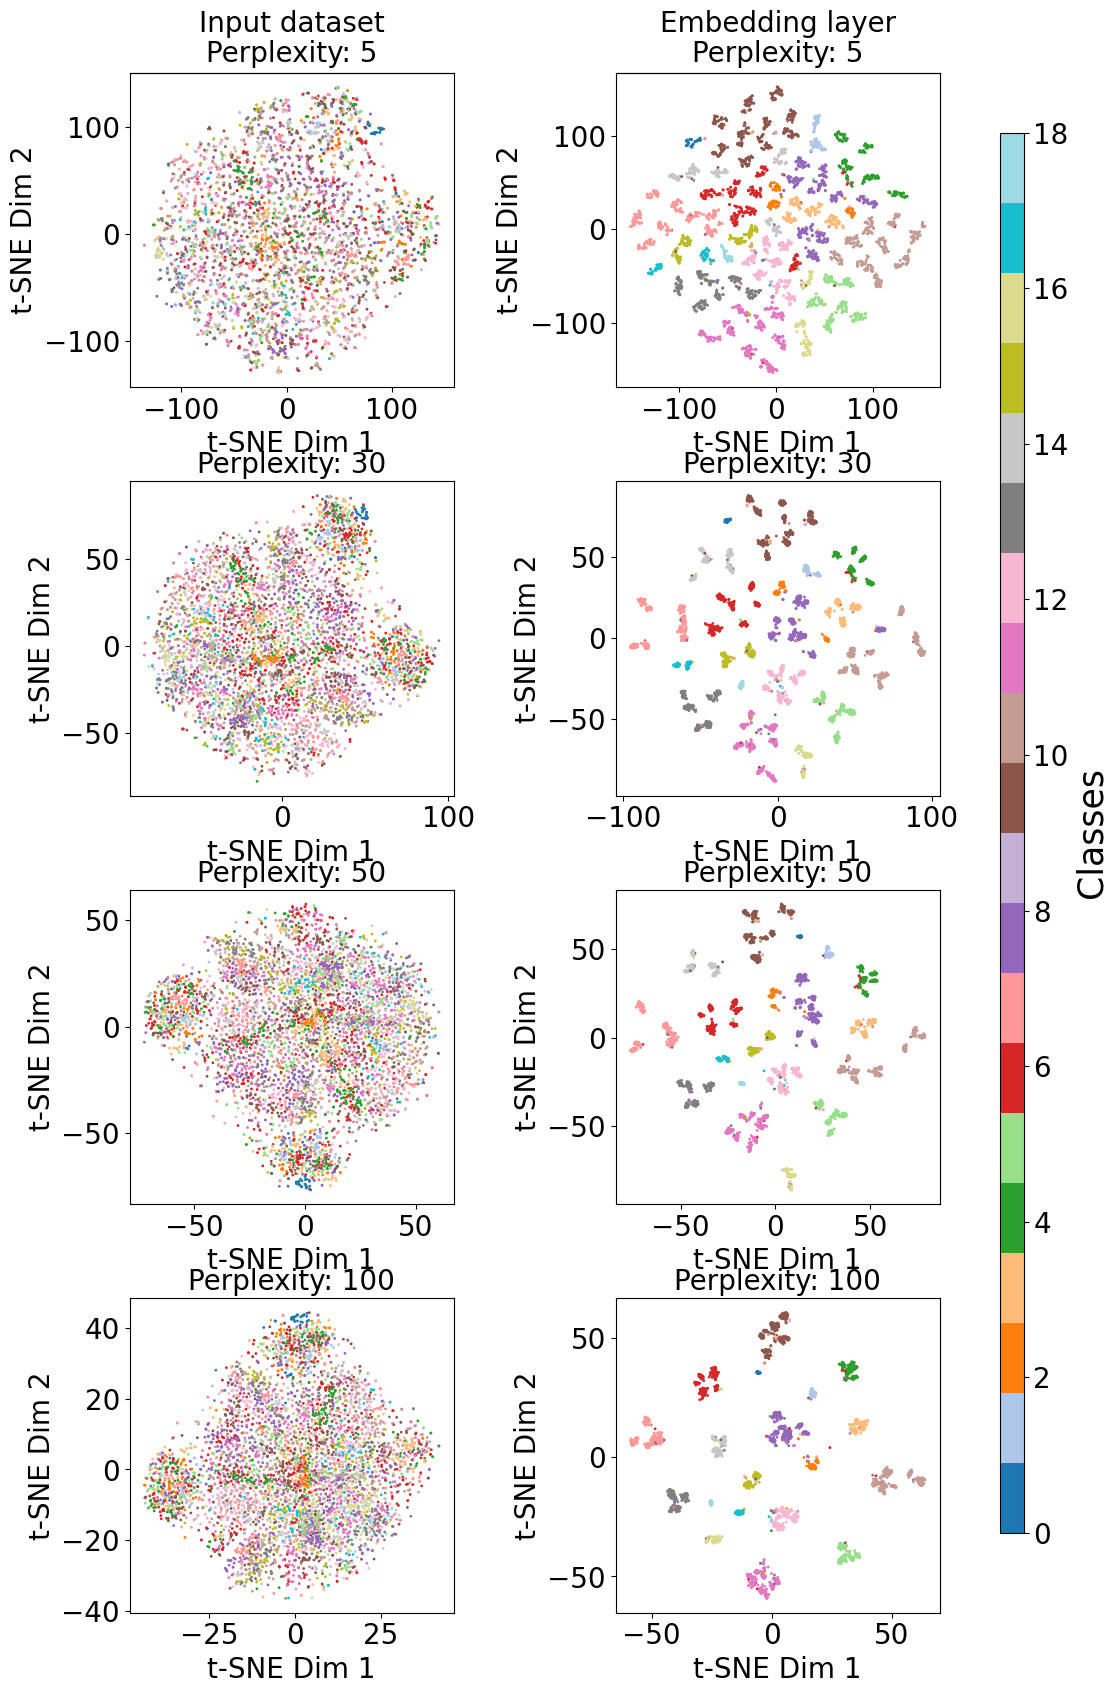

In [29]:
get_TSNE()

In [16]:
def optimise_tsne():

    x_train_flat = x_train.reshape(-1, 1568)
    y_train_flat = y_train.astype(int)

    embeddings, _ = get_embeddings(x_train, save=False)

    def objective(trial):
        perplexity = trial.suggest_int('perplexity', 5, 100)
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=441, max_iter=2000, n_iter_without_progress=400)
        model_embedded = tsne.fit_transform(embeddings[:5000])
        x_embedded = tsne.fit_transform(x_train_flat[:5000])
        model_embedded_score = silhouette_score(model_embedded, np.argmax(y_train_flat[:5000], axis=1))
        x_embedded_score = silhouette_score(x_embedded, np.argmax(y_train_flat[:5000],axis=1))

        score = np.average([model_embedded_score, x_embedded_score], weights=[0.75, 0.25])
        return score
    
    tsne_study = optuna.create_study(direction='maximize')

    tsne_study.optimize(objective, n_trials=10, show_progress_bar=True)

    with open("best_tsne.pkl", "wb") as f:
        pickle.dump(tsne_study, f)
    

In [17]:
optimise_tsne()

[I 2024-12-11 12:38:15,833] A new study created in memory with name: no-name-e07ca8ce-e68a-4d6d-b1f1-b6ee9b59fbdd


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-12-11 12:39:00,485] Trial 0 finished with value: 0.42910033091902733 and parameters: {'perplexity': 79}. Best is trial 0 with value: 0.42910033091902733.
[I 2024-12-11 12:39:31,701] Trial 1 finished with value: 0.12026948481798172 and parameters: {'perplexity': 18}. Best is trial 0 with value: 0.42910033091902733.
[I 2024-12-11 12:40:14,392] Trial 2 finished with value: 0.38897738233208656 and parameters: {'perplexity': 68}. Best is trial 0 with value: 0.42910033091902733.
[I 2024-12-11 12:41:00,733] Trial 3 finished with value: 0.4591136462986469 and parameters: {'perplexity': 88}. Best is trial 3 with value: 0.4591136462986469.
[I 2024-12-11 12:41:32,831] Trial 4 finished with value: 0.15729700028896332 and parameters: {'perplexity': 25}. Best is trial 3 with value: 0.4591136462986469.
[I 2024-12-11 12:42:14,259] Trial 5 finished with value: 0.3897910825908184 and parameters: {'perplexity': 66}. Best is trial 3 with value: 0.4591136462986469.
[I 2024-12-11 12:42:56,415] Trial

2024-12-18 08:41:06.097595: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501760000 exceeds 10% of free system memory.


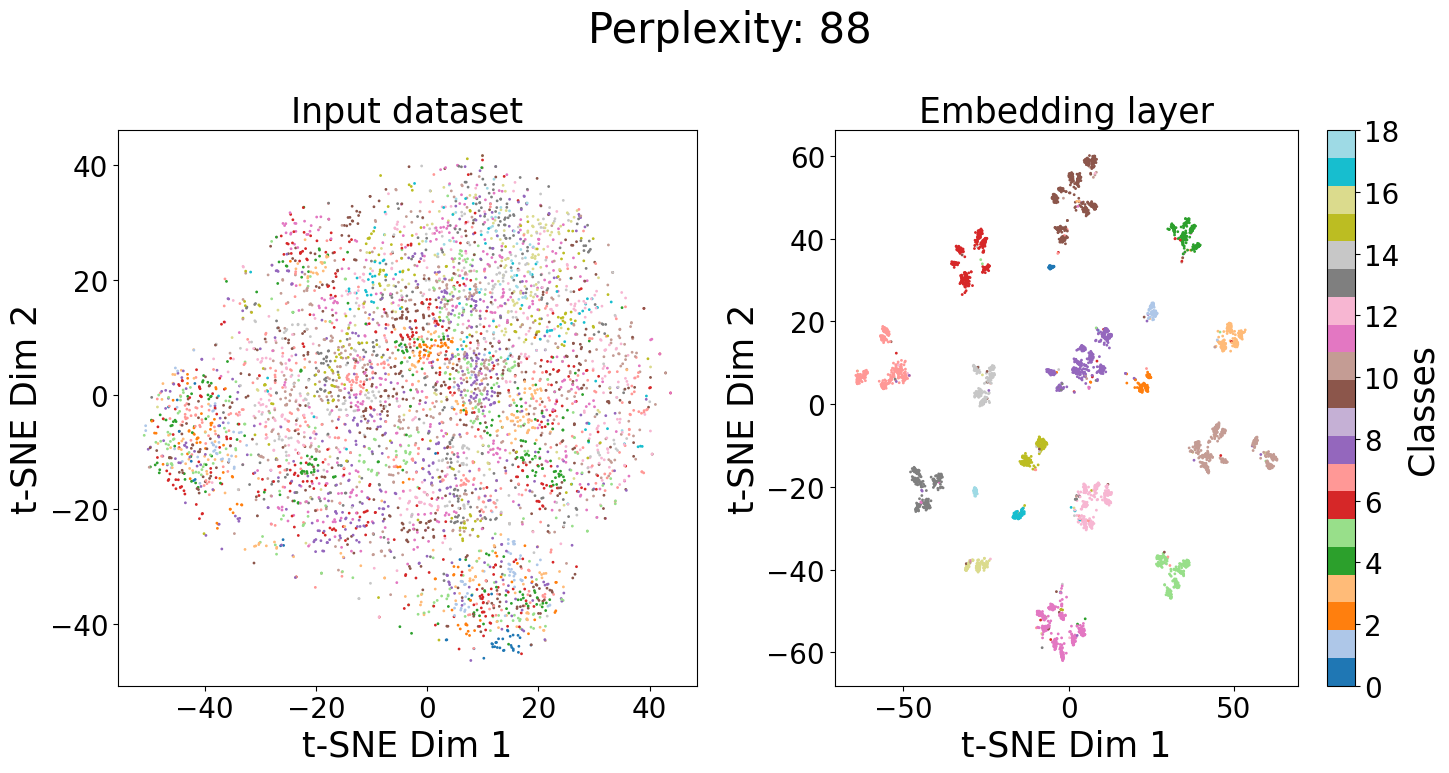

In [12]:
def get_opt_TSNE():
    with open(f'best_tsne.pkl', 'rb') as f:
        study = pickle.load(f)
    params = study.best_trial.params
    
    x_train_flat = x_train.reshape(-1, 1568)
    y_train_flat = y_train.astype(int)

    embeddings, _ = get_embeddings(x_train, save=False)

    tsne = TSNE(n_components=2, perplexity=params.get('perplexity'), random_state=441, max_iter=2000, n_iter_without_progress=400)
    model_embedded = tsne.fit_transform(embeddings[:5000])
    x_embedded = tsne.fit_transform(x_train_flat[:5000])

    fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
    fig.suptitle(f"Perplexity: {params.get('perplexity')}")
    axs[0].set_title(f"Input dataset", fontsize=25)
    axs[1].set_title(f"Embedding layer", fontsize=25)
        

    axs[0].scatter(x_embedded[:, 0], x_embedded[:, 1], c=np.argmax(y_train_flat[:5000], axis=1), cmap='tab20', s=1)
    axs[0].set_xlabel("t-SNE Dim 1")
    axs[0].set_ylabel("t-SNE Dim 2")

    model_scatter = axs[1].scatter(model_embedded[:, 0], model_embedded[:, 1], c=np.argmax(y_train_flat[:5000], axis=1), cmap='tab20', s=1)
    axs[1].set_xlabel("t-SNE Dim 1")
    axs[1].set_ylabel("t-SNE Dim 2")

    cbar = fig.colorbar(model_scatter, ax=axs[1], orientation='vertical', label='Classes')

    fig.tight_layout()
    fig.savefig("best_tsne.png")
    plt.show()
    

get_opt_TSNE()